In [1]:
import warnings
warnings.filterwarnings('ignore')

import random, re, time, xgboost
import numpy as np
from numpy.linalg import svd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency, skew
from sklearn.datasets import load_iris, make_classification, load_breast_cancer, load_boston, make_blobs
from sklearn import datasets, tree

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, PolynomialFeatures

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, confusion_matrix, f1_score, classification_report,\
    precision_recall_curve, roc_auc_score, mean_squared_error, r2_score,\
    mean_absolute_error, silhouette_samples, silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import plot_importance, XGBClassifier, XGBRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

### 군집화 실습: 고객 세그먼테이션

In [27]:
df = pd.read_excel(io=r'D:\hmkd1\m1_programming\[8] 머신러닝\Online_Retail.xlsx')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  int32         
 7   Country      354321 non-null  object        
 8   sale_amount  354321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 25.7+ MB


In [38]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df = df[df['CustomerID'].notnull()]
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
sale_amount    0
dtype: int64

In [39]:
df.Country.value_counts()[:5]

United Kingdom    354321
Name: Country, dtype: int64

In [40]:
df = df[df['Country']=='United Kingdom']
df.shape

(354321, 9)

### RFM기반 데이터 가공

In [41]:
df['sale_amount'] = df['Quantity'] * df['UnitPrice']
df['CustomerID'] = df['CustomerID'].astype(int)

In [42]:
df.CustomerID.value_counts().head(5)

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [43]:
df.groupby('CustomerID').agg({'sale_amount':'sum'}).reset_index().sort_values('sale_amount',ascending=False)[:5]

,CustomerID,sale_amount
3783,18102,259657.30
3314,17450,194550.79
2598,16446,168472.50
3356,17511,91062.38
2294,16029,81024.84


In [44]:
df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [49]:
aggregations = {
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'  }
cust_df = df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
            'InvoiceNo':'Frequency', 'sale_amount':'Monetarty'})

cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetarty
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [50]:
import datetime
cust_df['Recency'] = datetime.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)

print(f'cust_df의 shape: {cust_df.shape}')
cust_df.head(3)

cust_df의 shape: (3920, 4)


,CustomerID,Recency,Frequency,Monetarty
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


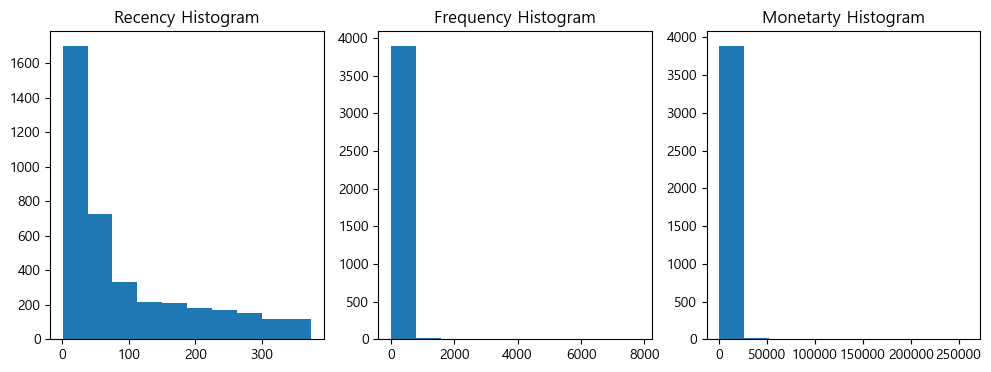

In [51]:
fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=3)

ax[0].hist(cust_df['Recency'])
ax[1].hist(cust_df['Frequency'])
ax[2].hist(cust_df['Monetarty'])

ax[0].set_title('Recency Histogram')
ax[1].set_title('Frequency Histogram')
ax[2].set_title('Monetarty Histogram')

plt.show()

In [53]:
cust_df[['Recency','Frequency','Monetarty']].describe()

,Recency,Frequency,Monetarty
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [57]:
xdf = cust_df.drop('CustomerID',axis=1).values
xdf_scaled = StandardScaler().fit_transform(xdf)

kmeans = KMeans(n_clusters=3, random_state=0)

labels = kmeans.fit_predict(xdf_scaled)
cust_df['cluster_label'] = labels
print(f'실루엣 스코어는: {silhouette_score(xdf_scaled, labels):.3f}')

실루엣 스코어는: 0.592


In [58]:
### 시각화 함수(강사님이 주심)

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [62]:
### 시각화 함수(강사님이 주심)

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

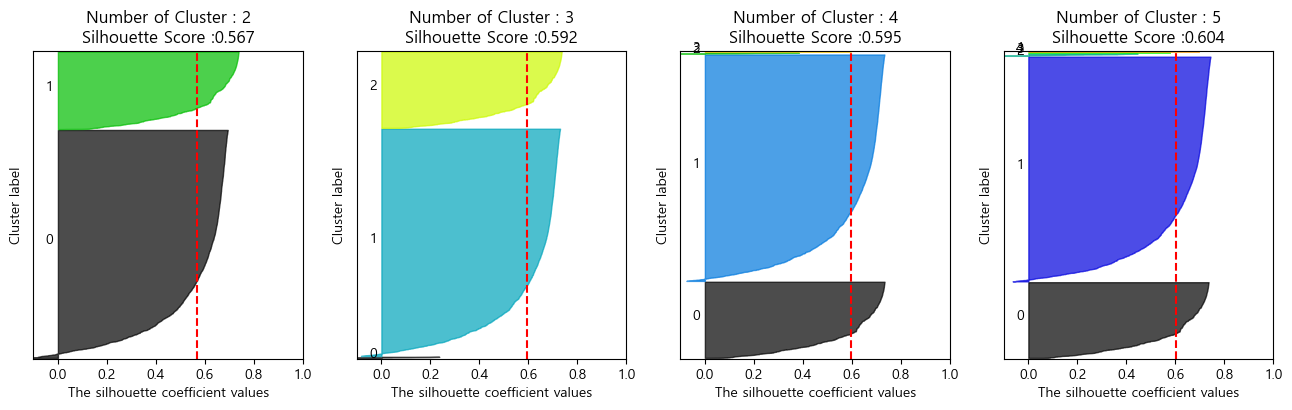

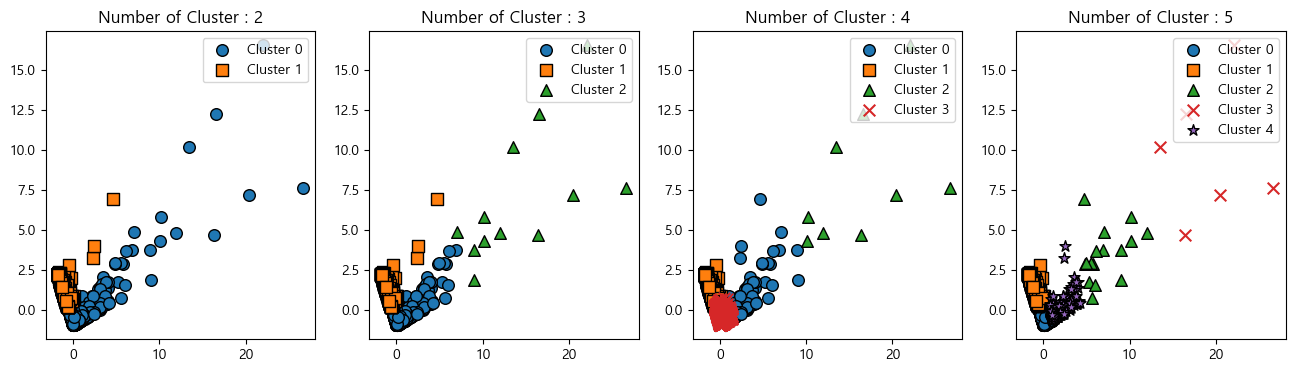

In [63]:
#시각화
visualize_silhouette([2,3,4,5], xdf_scaled)
visualize_kmeans_plot_multi([2,3,4,5], xdf_scaled)

실루엣 스코어는: 0.303


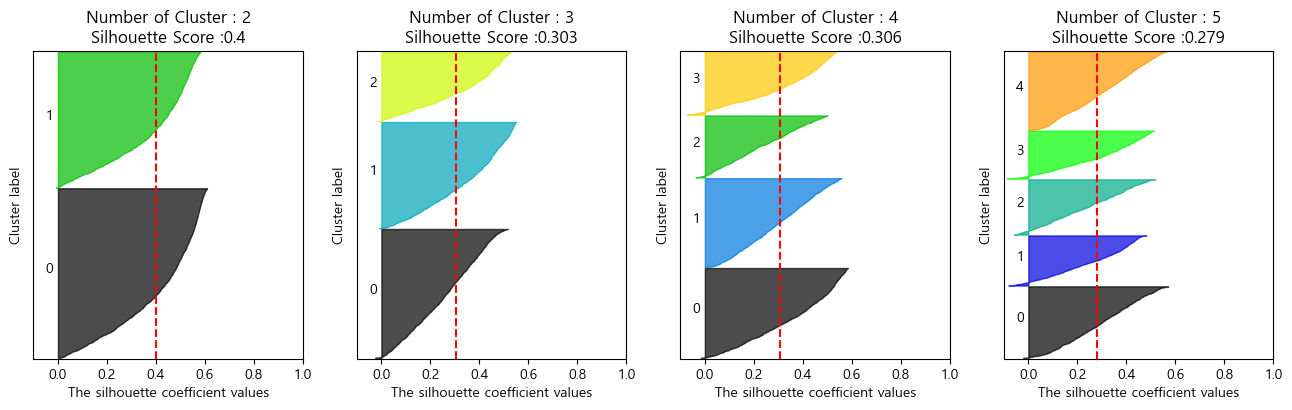

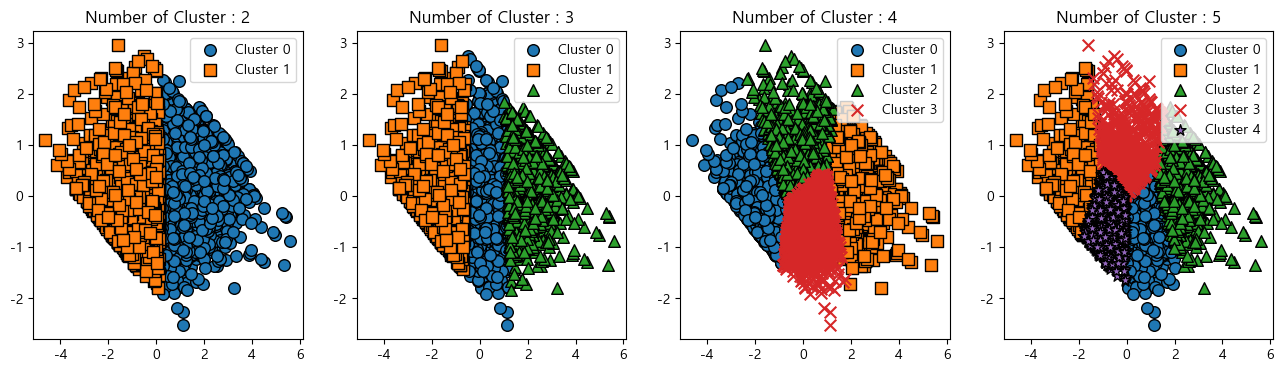

In [67]:
# 로그변환 추가
cust_df['Recency_log'] = np.log1p(cust_df.Recency)
cust_df['Frequency_log'] = np.log1p(cust_df.Frequency)
cust_df['Monetarty_log'] = np.log1p(cust_df.Monetarty)

xdf = cust_df[['Recency_log','Frequency_log','Monetarty_log']].values
xdf_scaled = StandardScaler().fit_transform(xdf)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(xdf_scaled)
cust_df['cluster_label'] = labels

print(f'실루엣 스코어는: {silhouette_score(xdf_scaled, labels):.3f}')
visualize_silhouette([2,3,4,5], xdf_scaled)
visualize_kmeans_plot_multi([2,3,4,5], xdf_scaled)